In [ ]:
!python -m spacy download fr_core_news_sm

2022-10-13 09:40:37.524144: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 209 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [ ]:

#imports
import spacy
from spacy.tokens import Doc
import json
import numpy as np


In [ ]:
def predict_pos(sentence, model):
  model.tokenizer = lambda x: Doc(model.vocab, x.split("|"))
  return [token.pos_ for token in model(sentence)]


model = spacy.load("fr_core_news_sm")

1-
A lambda function allows to get the result of a function, without having to declare such a function. As it is a single line function, it saves time and space.
On line 4 we use a lambda function to act as a 'constructor' and pass all parameters a Doc object needs.

2-
"[token.pos_ for token in model(sentence)]" is a list comprehension.
Here it defines a list of POS tags returned by the "fr_core_news_sm" model when applied to a sentence.

In [ ]:
def tag_sentences(sentences_list):
  pos_tagged_sentences = []
  for sentence in sentences_list:
    if type(sentence) == list:
      pos_list = predict_pos('|'.join(sentence), model)
    elif type(sentence) == str:
      pos_list = predict_pos(sentence.replace(" ","|"), model)
    pos_tagged_sentences.append(pos_list)
  return pos_tagged_sentences

print(tag_sentences([['Allez', '20 000',  'le' ,'foot', '!'],['Allez', '20 000',  'le' ,'foot', '!']]))
print(tag_sentences(["youpi le foot"]))

[['PROPN', 'NUM', 'DET', 'NOUN', 'PUNCT'], ['PROPN', 'NUM', 'DET', 'NOUN', 'PUNCT']]
[['NOUN', 'DET', 'NOUN']]


4. Why do we (have to) consider tokenized sentences to evaluate a PoS tagger?
We need to consider tokenized sentences instead of full sentences because it would be very difficult, costly to train a POS tagger on sentences, since it can exists an infinity of sentences: it would not make sense. That's why we are training and evaluating POS taggers on sequences of tokens, and not on full sentences.

In [ ]:
def compute_accuracy(prediction_list, gold_list):
  sentences_count = len(prediction_list)
  well_tagged_sentences = sum([pred==gold for pred, gold in zip(prediction_list, gold_list)])
  return 1/sentences_count * well_tagged_sentences

def compute_micro_accuracy(prediction_list, gold_list):
  prediction_list = list(np.concatenate(prediction_list))
  gold_list = list(np.concatenate(gold_list))
  well_tagged_words = 0
  well_tagged_words += sum([pred==gold for pred, gold in zip(prediction_list, gold_list)])
  return 1/len(gold_list) * well_tagged_words

def compute_macro_accuracy(prediction_list, gold_list):
    prediction_list = list(np.concatenate(prediction_list))
    gold_list = list(np.concatenate(gold_list))
    tag_dict = {}
    for pred, gold in zip(prediction_list, gold_list):
        if pred == gold:
            tag_dict[gold] = tag_dict.setdefault(gold, 0) + 1
    accuracy = sum([tag_dict.get(tag)/gold_list.count(tag) for tag in tag_dict])
    return accuracy / len(tag_dict)

def compute_sentence_error_rate(prediction_list, gold_list):
  return 1- compute_accuracy(prediction_list, gold_list)

def compute_word_error_rate(prediction_list, gold_list):
  return 1- compute_micro_accuracy(prediction_list, gold_list)

In [ ]:
import pandas as pd
import requests
import re
def read_json_github(path):
  corpus = requests.get(path).json()
  golds = []
  if(re.match(".+sequoia.test.json$", path)):
    golds = [dico.get("gold_labels") for dico in corpus]
  elif(re.match(".+minecraft.json", path)):
    golds = [dico.get("gold_tags") for dico in corpus]
  tokens = [dico.get("tokenized_sentence") for dico in corpus]
  return tokens, golds

sequoia_tokens, sequoia_gold = read_json_github("https://raw.githubusercontent.com/g-armand/make-it-public/main/sequoia.test.json")
sequoia_pred = tag_sentences(sequoia_tokens)
print("sentence accuracy: ",compute_accuracy(sequoia_pred, sequoia_gold))
print("micro accuracy: ", compute_micro_accuracy(sequoia_pred, sequoia_gold))
print("macro accuracy: ", compute_macro_accuracy(sequoia_pred, sequoia_gold))


sentence accuracy:  0.5899122807017544
micro accuracy:  0.9639585822381521
macro accuracy:  0.8855232239448435


In [ ]:
print("there are {} sentences in corpus".format(len(sequoia_tokens)))
print("there are {} words in corpus".format(sum([len(sentence) for sentence in sequoia_tokens])))

there are 456 sentences in corpus
there are 10044 words in corpus


In [ ]:
import random
def compute_error_rate_random(func, sample, sample_size):
    sample = random.sample(sample, sample_size * len(sample) // 100)
    sentences = [tup[0] for tup in sample]
    gold = [tup[1] for tup in sample]
    return func(sentences, gold)

sample = [(pred, gold) for pred, gold in zip(sequoia_pred, sequoia_gold)]
print(compute_error_rate_random(compute_macro_accuracy,sample, 80))
print(compute_error_rate_random(compute_micro_accuracy,sample, 80))
print(compute_error_rate_random(compute_accuracy,sample, 80))

0.8747433268706146
0.9649829184968277
0.5961538461538461


Question 10:
The code below computes 1000 times the sentence accuracy from a random sample (sample size = 50% of the corpus). When visualizing the scores distribution, we notice that the score obtained on the sample is most of the time between 0.56 and 0.62. We can conclude that the average accuracy should be between these two values, which is true because we found earlier that the score is 0.6016.

min: 0.5087719298245614
max: 0.6710526315789473


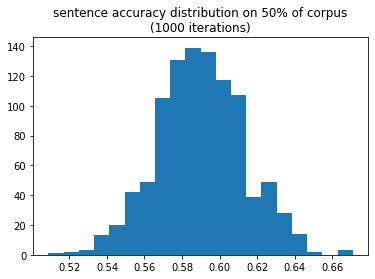

In [ ]:
import matplotlib.pyplot as plt

def compute_accuracies_n_corpora(foo,n):
  size = 50
  liste = [compute_error_rate_random(foo, sample, size) for _ in range(n)]
  plt.hist(liste, bins=20)
  plt.title(f"sentence accuracy distribution on {size}% of corpus\n({n} iterations)")
  return liste
liste = compute_accuracies_n_corpora(compute_accuracy, 1000)
print(f"min: {min(liste)}")
print(f"max: {max(liste)}")


Question 11:
The code below computes the average and the standard deviation values of the POS tagger performance on larger and larger parts of the corpus. the greater the part of the corpus we consider, the more precise our results get. We can conclde that the bigger the test sample is, and the closer it will be from the value obtained on 100% of the corpus. Also, it is important to note that the values obtained on 10% of the corpus are somehow precise, already giving a rough idea on what the tagger precision is.

In [ ]:
def compute_accuracy_n_percent_corpora(foo):
  for n in range(10,110, 10):
    liste = [compute_error_rate_random(foo, sample, n) for _ in range(10)]
    print(f"{n}% of corpus: average = {str(np.average(liste))[:6]}, standard deviation: {str(np.std(liste))[:6]}")
compute_accuracy_n_percent_corpora(compute_accuracy)

10% of corpus: average = 0.5622, standard deviation: 0.0795
20% of corpus: average = 0.5890, standard deviation: 0.0381
30% of corpus: average = 0.6029, standard deviation: 0.0352
40% of corpus: average = 0.5791, standard deviation: 0.0255
50% of corpus: average = 0.5956, standard deviation: 0.0198
60% of corpus: average = 0.5945, standard deviation: 0.0200
70% of corpus: average = 0.5884, standard deviation: 0.0141
80% of corpus: average = 0.5912, standard deviation: 0.0047
90% of corpus: average = 0.5892, standard deviation: 0.0067
100% of corpus: average = 0.5899, standard deviation: 0.0


Question 12:
The error rate obtained on Sequoia corpus might be similar to the one obtained on the three next corpora since all of them are built from French sentences. But, despite being all French sentences, the source is different (oral, wikipedia, Minecraft...) which might result in changes in structure, vocabulary, leading towards better or worse results depending on such parameters...

In [ ]:
import re
def load_ud_files(path):
  text = requests.get(path).text
  text =  text.split("\n#")
  main_tokens = []
  main_golds = []
  for sentence in text:
    tokens = [s.split("\t")[1] for s in sentence.split("\n") if re.match("^[0-9]", s)]
    golds = [s.split("\t")[3] for s in sentence.split("\n") if re.match("^[0-9]", s)]
    if len(tokens) >= 1:
       main_tokens.append(tokens)
       main_golds.append(golds)
  return main_tokens, main_golds

parisstories_tokens, parisstories_golds = load_ud_files("https://raw.githubusercontent.com/g-armand/make-it-public/main/fr_parisstories-ud-test.txt")
parisstories_pred = tag_sentences(parisstories_tokens)
print("parisstories sentence accuracy:", str(compute_accuracy(parisstories_pred, parisstories_golds))[:6])
print("parisstories macro accuracy:", str(compute_macro_accuracy(parisstories_pred, parisstories_golds))[:6])
print("parisstories micro accuracy:", str(compute_micro_accuracy(parisstories_pred, parisstories_golds))[:6], "\n")

frgsd_tokens, frgsd_golds = load_ud_files("https://raw.githubusercontent.com/g-armand/make-it-public/main/fr_gsd-ud-test.txt")
frgsd_pred = tag_sentences(frgsd_tokens)
print("frgsd sentence accuracy:", str(compute_accuracy(frgsd_pred, frgsd_golds))[:6])
print("frgsd macro accuracy:", str(compute_macro_accuracy(frgsd_pred, frgsd_golds))[:6])
print("frgsd micro accuracy:", str(compute_micro_accuracy(frgsd_pred, frgsd_golds))[:6],"\n")

minecraft_tokens, minecraft_golds = read_json_github(  "https://raw.githubusercontent.com/g-armand/make-it-public/main/minecraft.json")
minecraft_pred = tag_sentences(minecraft_tokens)
print("minecraft sentence accuracy:", str(compute_accuracy(minecraft_pred, minecraft_golds))[:6])
print("minecraft macro accuracy:", str(compute_macro_accuracy(minecraft_pred, minecraft_golds))[:6])
print("minecraft micro accuracy:", str(compute_micro_accuracy(minecraft_pred, minecraft_golds))[:6])

parisstories sentence accuracy: 0.1334
parisstories macro accuracy: 0.8094
parisstories micro accuracy: 0.8444 

frgsd sentence accuracy: 0.1947
frgsd macro accuracy: 0.7964
frgsd micro accuracy: 0.8952 

minecraft sentence accuracy: 0.0598
minecraft macro accuracy: 0.5376
minecraft micro accuracy: 0.4455
